#### Copyright 2017 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# BAM1D Physics Emulation

**Objective:** Emulate the Hugo Morrison Microphysics implemented in BAM1D


## Setup

First, we'll load the data.

In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

# tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

original_input_df = pd.read_csv("/home/denis/_COM_BACKUP/bam1d_physics_nn/hug_morr_inputs.csv", sep=",")
original_output_df = pd.read_csv("/home/denis/_COM_BACKUP/bam1d_physics_nn/hug_morr_outputs.csv", sep=",")

input_df = original_input_df.reindex(np.random.permutation(original_input_df.index))
output_df = original_output_df.reindex(np.random.permutation(original_output_df.index))

# california_housing_dataframe = california_housing_dataframe.reindex(
#    np.random.permutation(california_housing_dataframe.index))

In [2]:
def preprocess_features(input_df):
  """Prepares input features input_df

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
# All input variables
# "k", "si", "si_kmax_+_1", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "gps", "omega"    
  selected_features = input_df[
    [
    "k", "si", "si_kmax_+_1", "sl", "Tc", "qv", "qc", "qr", "qi", "qs",
    "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "gps", "omega"    
    ]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
#   processed_features["rooms_per_person"] = (
#     california_housing_dataframe["total_rooms"] /
#     california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(output_df):
  """Prepares target features (i.e., labels) from output_df

  Args:
    output_df: A Pandas DataFrame expected to contain data
      from output data set.
  Returns:
    A DataFrame that contains the target features.
  """
# All output variables
# "k", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
  output_targets = output_df [
      [
      "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
      ]
  ]
#   # Scale the target to be in units of thousands of dollars.
#   output_targets["median_house_value"] = (
#     output_df["median_house_value"] / 1000.0)
  return output_targets

In [3]:
all_examples = preprocess_features(input_df)
all_targets = preprocess_targets(output_df)

print("All input summary:")
display.display(all_examples.describe())

print("All output summary:")
display.display(all_targets.describe())


All input summary:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
count,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0
mean,14.5,0.5,0.0,0.5,240.9,0.0,0.0,0.0,0.0,0.0,0.0,61165.5,1043501.1,4576.1,0.0,121900.3,0.3,28.6,99000.0,-0.0
std,8.1,0.4,0.0,0.4,57.6,0.0,0.0,0.0,0.0,0.0,0.0,278606.7,3399577.6,51098.1,0.1,980184.9,1.1,78.9,0.0,0.1
min,1.0,0.0,0.0,0.0,76.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99000.0,-1.0
25%,7.8,0.1,0.0,0.1,199.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,99000.0,-0.0
50%,14.5,0.4,0.0,0.4,260.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.7,0.0,0.0,0.0,0.0,0.1,99000.0,0.0
75%,21.2,0.8,0.0,0.8,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42529.6,0.0,0.0,0.0,0.0,0.1,99000.0,0.0
max,28.0,1.0,0.0,1.0,310.3,0.0,0.0,0.0,0.0,0.0,0.0,1744027.0,22604778.8,1740941.7,21.0,22999125.0,6.0,300.0,99000.0,0.2


All output summary:


,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0
mean,240.9,0.0,0.0,0.0,0.0,0.0,0.0,61176.0,1043612.4,4576.1,0.0,121900.3,24.6,28.4,0.0,0.0
std,57.6,0.0,0.0,0.0,0.0,0.0,0.0,278629.6,3399730.1,51098.1,0.1,980184.9,2.5,14.6,0.0,0.0
min,76.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,-0.0,0.0
25%,199.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
50%,260.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.7,0.0,0.0,0.0,25.0,25.0,0.0,0.0
75%,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42531.5,0.0,0.0,0.0,25.0,25.0,0.0,0.0
max,310.3,0.0,0.0,0.0,0.0,0.0,0.0,1744027.0,22604778.8,1740941.7,21.0,22999125.0,27.6,130.0,0.0,0.0


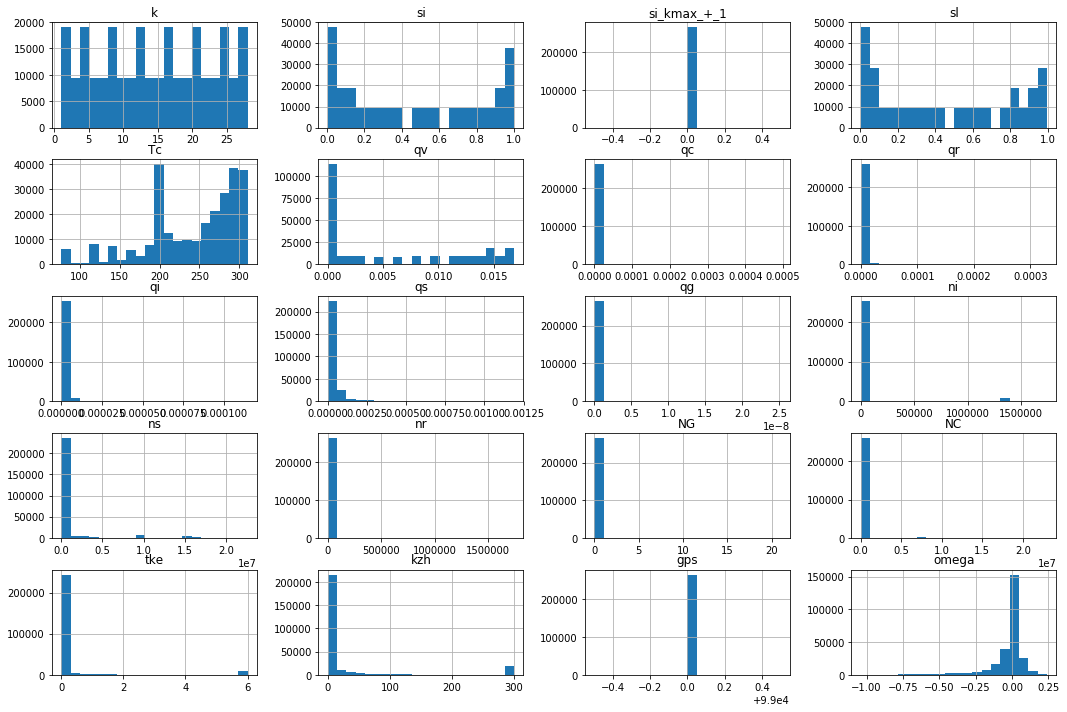

In [4]:
# Input Histograms

_ = all_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

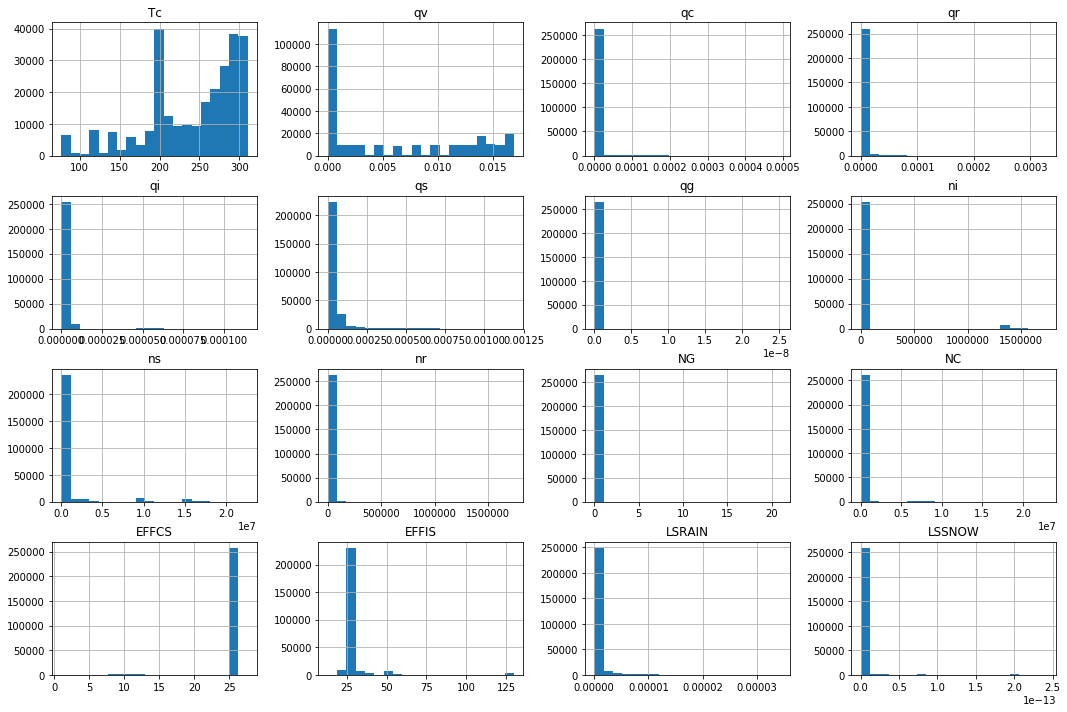

In [5]:
# Output Histograms

_ = all_targets.hist(bins=20, figsize=(18, 12), xlabelsize=10)
#_ = validation_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

In [6]:
# Choose variables to train and validate
# Eliminate variables are not varying
# Separate 70% for training and 30# for validation

all_examples = all_examples.drop(["si_kmax_+_1", "gps"], axis=1)
# all_targets = all_targets.drop(["???"], axis=1)

# Choose the first 185828 (70%) (out of 265469) for training.
training_examples = all_examples.head(185828)
training_targets = all_targets.head(185828)

# Choose the last 79641 (30%) (out of 265469) for validation.
validation_examples = all_examples.tail(79641)
validation_targets = all_targets.tail(79641)


print("Training examples summary:")
display.display(training_examples.describe())

print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())

print("Validation targets summary:")
display.display(validation_targets.describe())


Training examples summary:


,k,si,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,omega
count,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0
mean,14.5,0.5,0.5,240.9,0.0,0.0,0.0,0.0,0.0,0.0,61410.9,1047480.3,4542.7,0.0,122496.4,0.3,28.8,-0.0
std,8.1,0.4,0.4,57.7,0.0,0.0,0.0,0.0,0.0,0.0,279180.7,3407750.8,50600.1,0.1,983061.4,1.1,79.0,0.1
min,1.0,0.0,0.0,76.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
25%,7.0,0.1,0.1,199.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,-0.0
50%,14.0,0.5,0.4,260.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6,0.0,0.0,0.0,0.0,0.1,0.0
75%,22.0,0.9,0.8,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42532.5,0.0,0.0,0.0,0.0,0.1,0.0
max,28.0,1.0,1.0,310.3,0.0,0.0,0.0,0.0,0.0,0.0,1744027.0,22363838.7,1734728.0,13.5,22994577.7,6.0,300.0,0.2


Validation examples summary:


,k,si,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,omega
count,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0
mean,14.5,0.5,0.5,241.1,0.0,0.0,0.0,0.0,0.0,0.0,60592.2,1034203.7,4654.0,0.0,120507.9,0.3,28.4,-0.0
std,8.1,0.4,0.4,57.5,0.0,0.0,0.0,0.0,0.0,0.0,277262.0,3380413.4,52241.5,0.1,973438.7,1.1,78.5,0.1
min,1.0,0.0,0.0,76.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
25%,8.0,0.1,0.1,199.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,-0.0
50%,15.0,0.4,0.4,259.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.1,0.0,0.0,0.0,0.0,0.1,0.0
75%,21.0,0.8,0.8,289.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42393.7,0.0,0.0,0.0,0.0,0.1,0.0
max,28.0,1.0,1.0,310.3,0.0,0.0,0.0,0.0,0.0,0.0,1743912.6,22604778.8,1740941.7,21.0,22999125.0,6.0,300.0,0.2


Training targets summary:


,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0
mean,241.0,0.0,0.0,0.0,0.0,0.0,0.0,61291.1,1046423.0,4533.9,0.0,121974.6,24.6,28.4,0.0,0.0
std,57.7,0.0,0.0,0.0,0.0,0.0,0.0,278984.9,3404360.5,50934.0,0.1,976981.8,2.5,14.5,0.0,0.0
min,76.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,-0.0,0.0
25%,199.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
50%,261.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6,0.0,0.0,0.0,25.0,25.0,0.0,0.0
75%,290.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42354.8,0.0,0.0,0.0,25.0,25.0,0.0,0.0
max,310.3,0.0,0.0,0.0,0.0,0.0,0.0,1744027.0,22604778.8,1740941.7,21.0,22994577.7,27.6,130.0,0.0,0.0


Validation targets summary:


,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0
mean,240.7,0.0,0.0,0.0,0.0,0.0,0.0,60906.8,1037041.3,4674.5,0.0,121725.6,24.6,28.5,0.0,0.0
std,57.6,0.0,0.0,0.0,0.0,0.0,0.0,277798.7,3388894.1,51478.9,0.1,987618.4,2.5,14.9,0.0,0.0
min,76.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,-0.0,0.0
25%,199.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
50%,258.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
75%,289.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43095.3,0.0,0.0,0.0,25.0,25.0,0.0,0.0
max,310.3,0.0,0.0,0.0,0.0,0.0,0.0,1743787.6,22505750.7,1392943.5,17.1,22999125.0,25.0,130.0,0.0,0.0


Training examples summary:


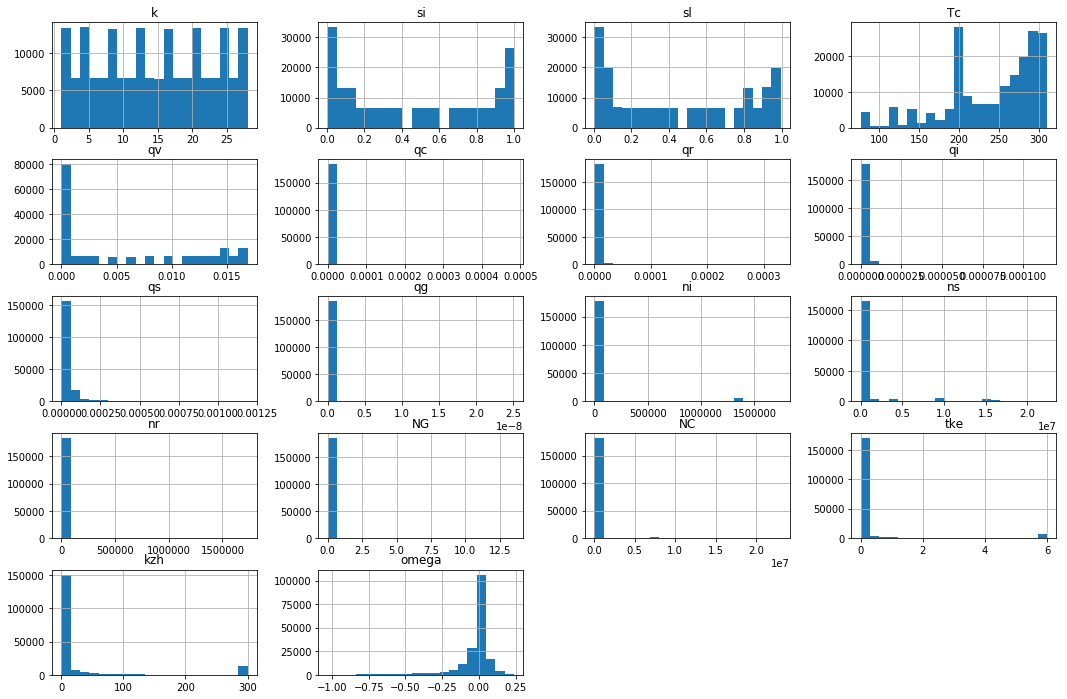

Validation examples summary:


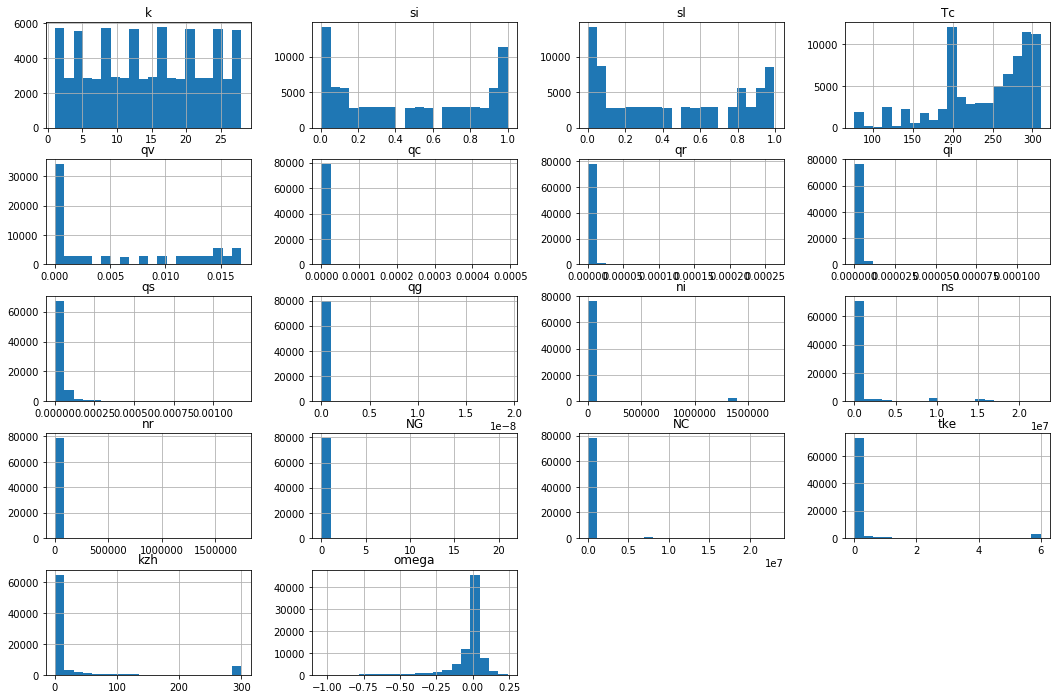

Training targets summary:


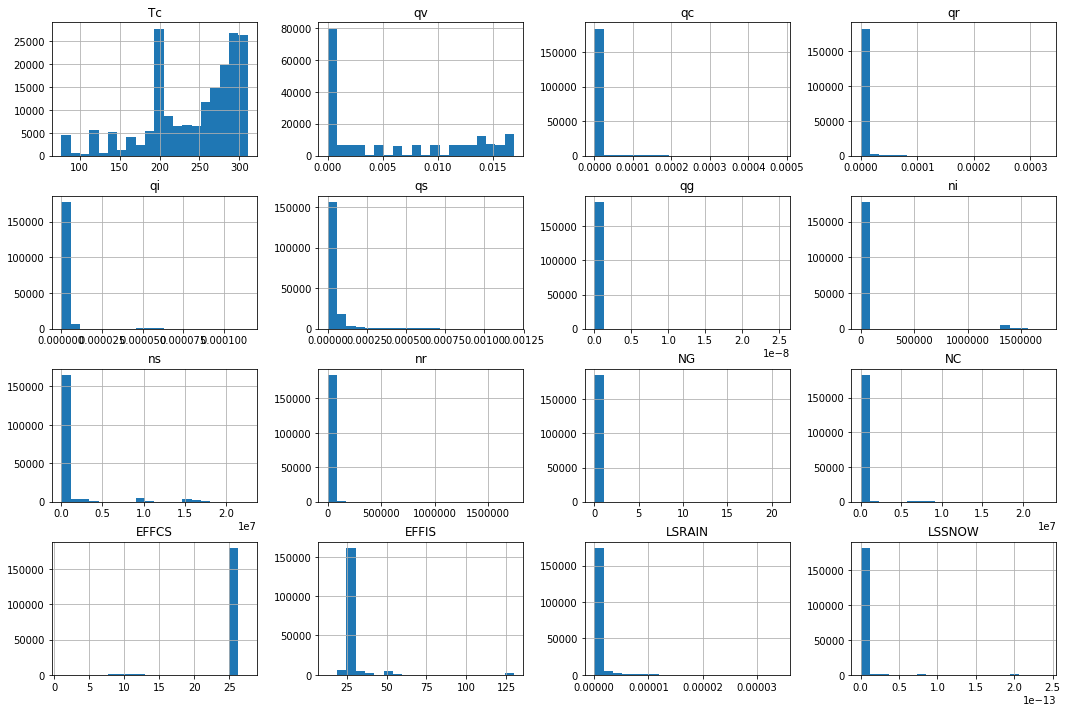

Validation targets summary:


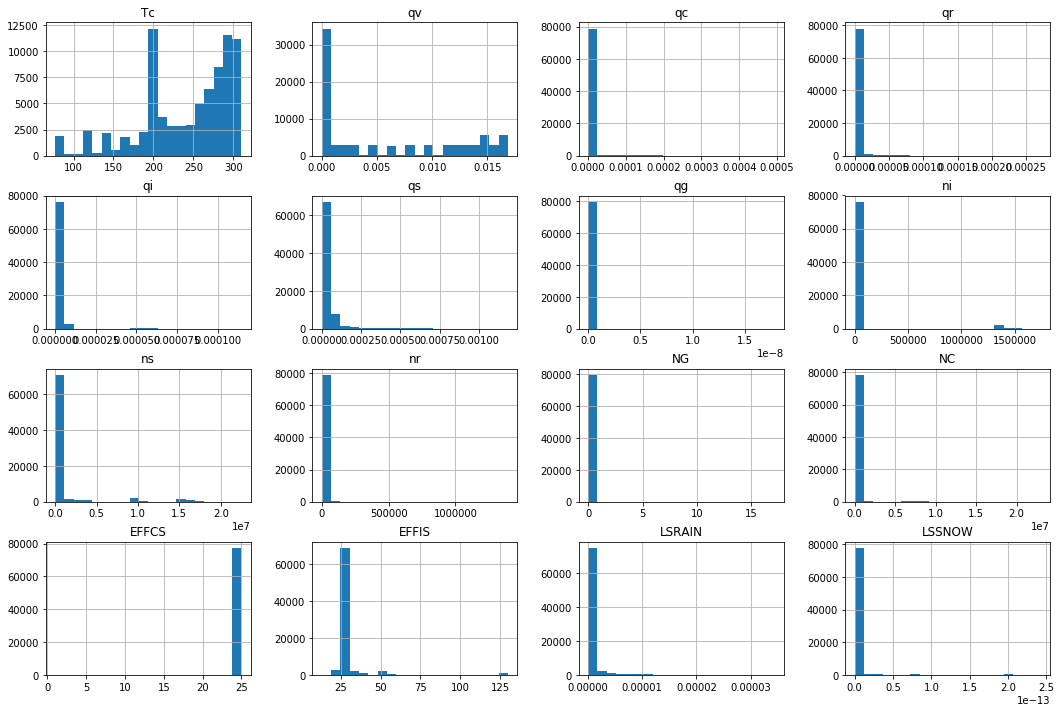

In [7]:
# Histogram of choosen variables of train and validation

print("Training examples summary:")
training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)
plt.show()

print("Validation examples summary:")
validation_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)
plt.show()

print("Training targets summary:")
training_targets.hist(bins=20, figsize=(18, 12), xlabelsize=10)
plt.show()

print("Validation targets summary:")
validation_targets.hist(bins=20, figsize=(18, 12), xlabelsize=10)
plt.show()


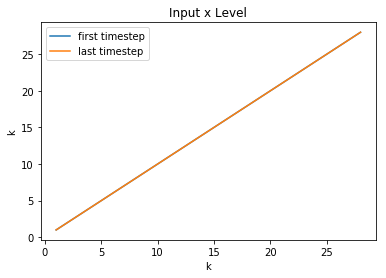

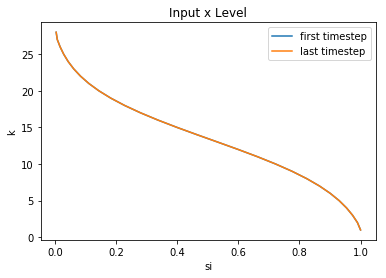

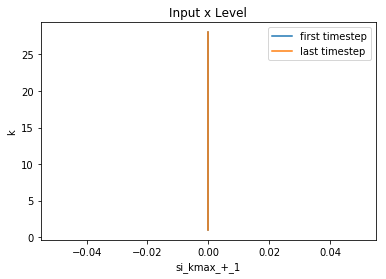

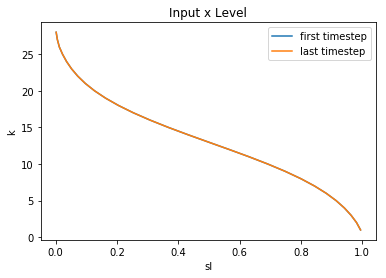

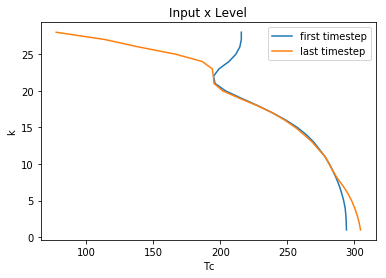

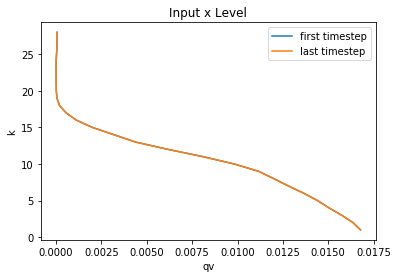

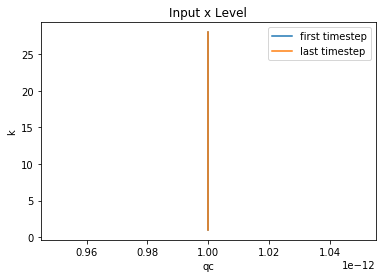

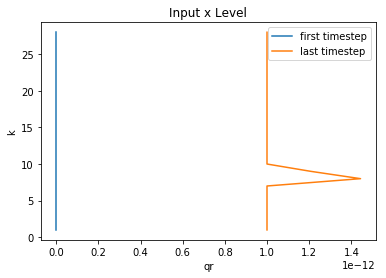

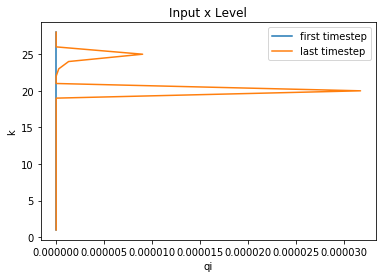

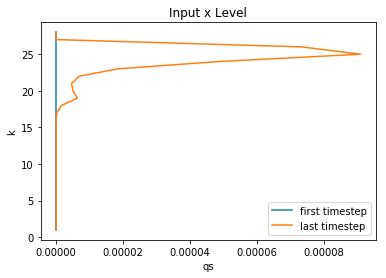

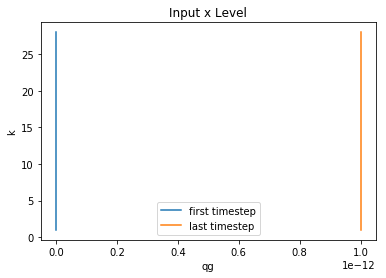

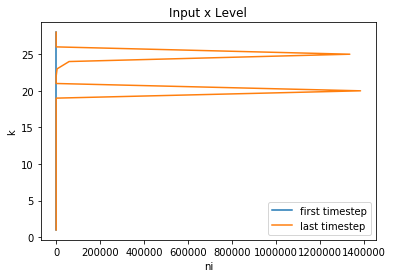

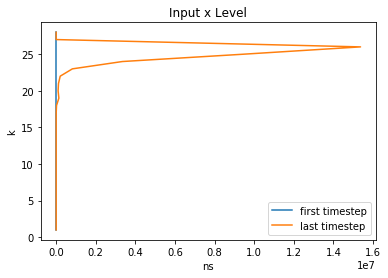

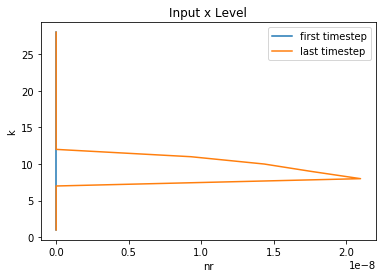

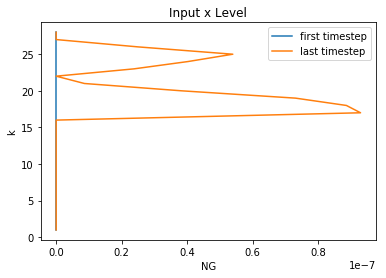

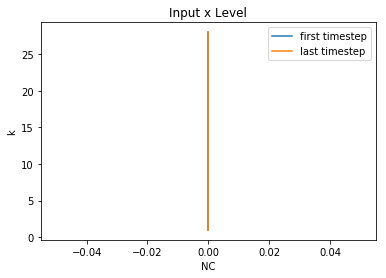

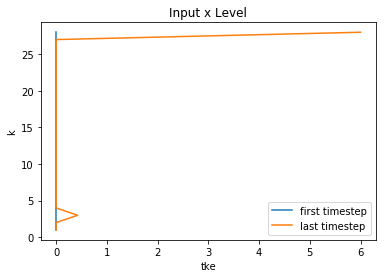

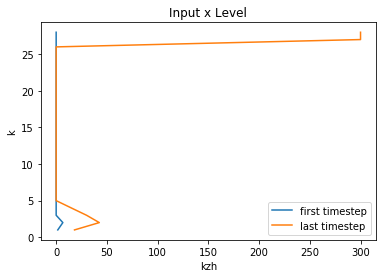

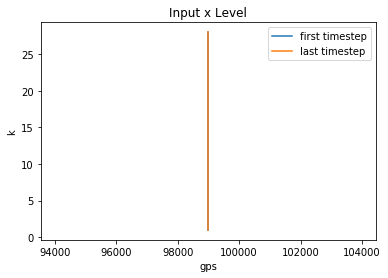

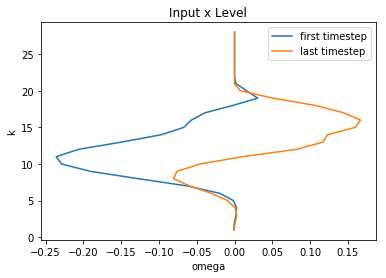

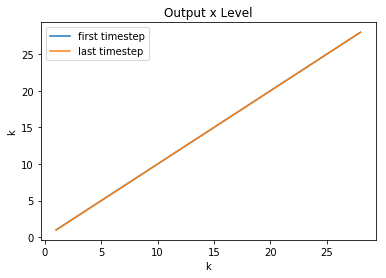

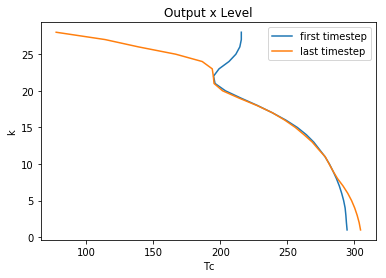

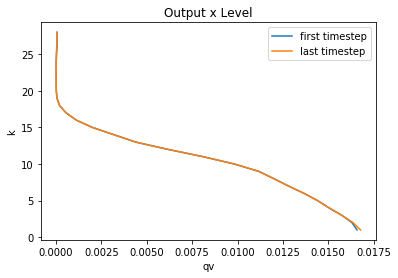

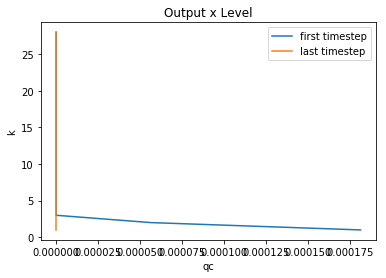

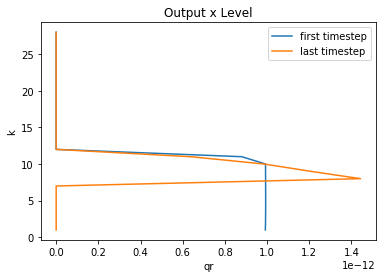

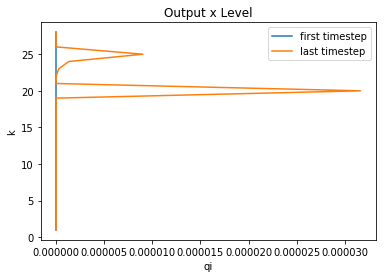

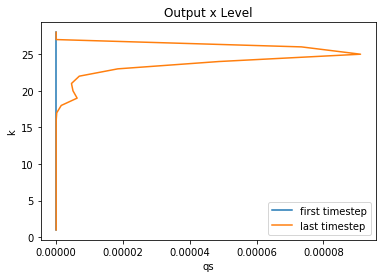

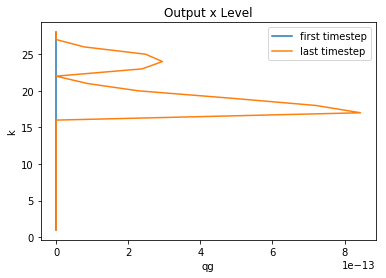

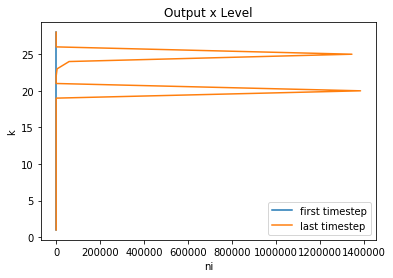

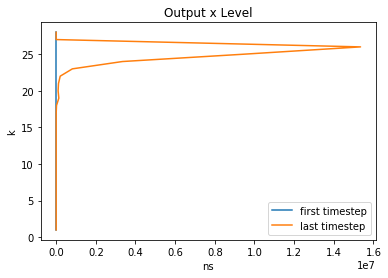

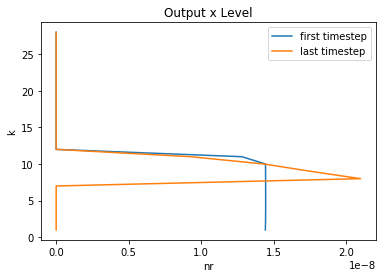

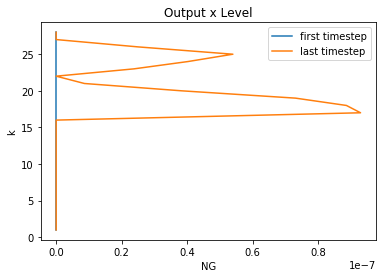

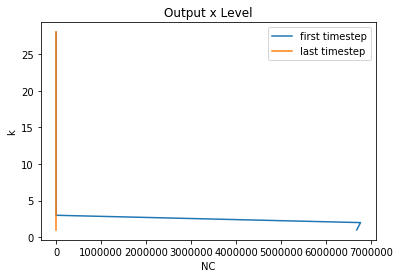

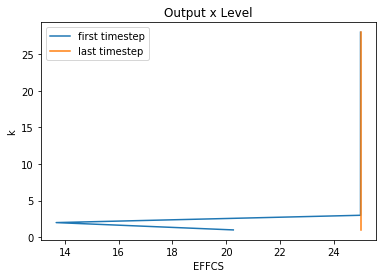

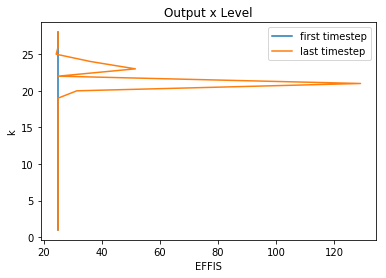

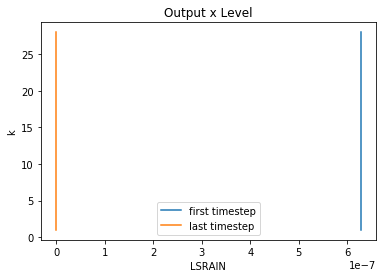

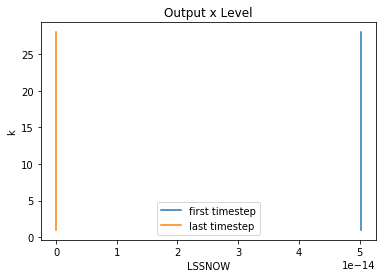

In [8]:
# Plot de variáveis de input e output por nível k

# all_examples[["si", "k"]]

first_timestep_input_df = original_input_df.head(28)
last_timestep_input_df = original_input_df.tail(28)

for key in last_timestep_input_df.columns.tolist():
    plt.ylabel("k")
    plt.xlabel(key)
    plt.title("Input x Level")
    plt.plot(first_timestep_input_df[key], first_timestep_input_df[["k"]], label="first timestep")
    plt.plot(last_timestep_input_df[key], last_timestep_input_df[["k"]], label="last timestep")
    plt.legend()
    plt.show()

first_timestep_output_df = original_output_df.head(28)
last_timestep_output_df = original_output_df.tail(28)

for key in last_timestep_output_df.columns.tolist():
    plt.ylabel("k")
    plt.xlabel(key)
    plt.title("Output x Level")
    plt.plot(first_timestep_output_df[key], first_timestep_output_df[["k"]], label="first timestep")
    plt.plot(last_timestep_output_df[key], last_timestep_output_df[["k"]], label="last timestep")
    plt.legend()
    plt.show()

## Train the Neural Network

Next, we'll train the neural network.

In [6]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [7]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [8]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 171.44
  period 01 : 161.53
  period 02 : 150.00
  period 03 : 134.58
  period 04 : 122.81
  period 05 : 110.40
  period 06 : 106.86
  period 07 : 104.24
  period 08 : 104.16
  period 09 : 110.50
Model training finished.
Final RMSE (on training data):   110.50
Final RMSE (on validation data): 112.81


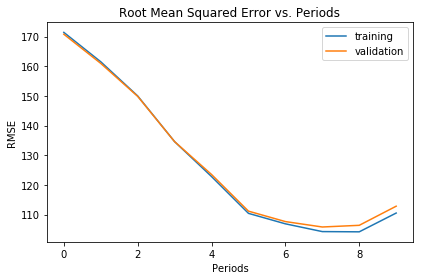

In [9]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Linear Scaling
It can be a good standard practice to normalize the inputs to fall within the range -1, 1. This helps SGD not get stuck taking steps that are too large in one dimension, or too small in another. Fans of numerical optimization may note that there's a connection to the idea of using a preconditioner here.

In [10]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

## Task 1: Normalize the Features Using Linear Scaling

**Normalize the inputs to the scale -1, 1.**

**Spend about 5 minutes training and evaluating on the newly normalized data.  How well can you do?**

As a rule of thumb, NN's train best when the input features are roughly on the same scale.

Sanity check your normalized data.  (What would happen if you forgot to normalize one feature?)


Training model...
RMSE (on training data):
  period 00 : 148.54
  period 01 : 112.74
  period 02 : 98.71
  period 03 : 81.08
  period 04 : 75.51
  period 05 : 73.64
  period 06 : 72.22
  period 07 : 71.43
  period 08 : 70.88
  period 09 : 70.13
Model training finished.
Final RMSE (on training data):   70.13
Final RMSE (on validation data): 72.03


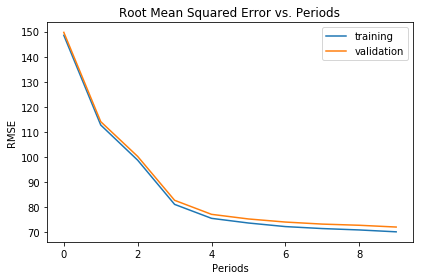

In [11]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  #
  # Your code here: normalize the inputs.
  #
    # Convert pandas data into a dict of np arrays.
#   processed_features = pd.DataFrame()
  processed_features = examples_dataframe
  for key,value in dict(examples_dataframe).items():
    processed_features[key] = linear_scale(value)
  return processed_features


normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

### Solution

Click below for one possible solution.

Since normalization uses min and max, we have to ensure it's done on the entire dataset at once. 

We can do that here because all our data is in a single DataFrame. If we had multiple data sets, a good practice would be to derive the normalization parameters from the training set and apply those identically to the test set.

Training model...
RMSE (on training data):
  period 00 : 160.15
  period 01 : 112.48
  period 02 : 100.73
  period 03 : 84.82
  period 04 : 77.49
  period 05 : 74.97
  period 06 : 73.09
  period 07 : 72.03
  period 08 : 71.03
  period 09 : 70.50
Model training finished.
Final RMSE (on training data):   70.50
Final RMSE (on validation data): 72.40


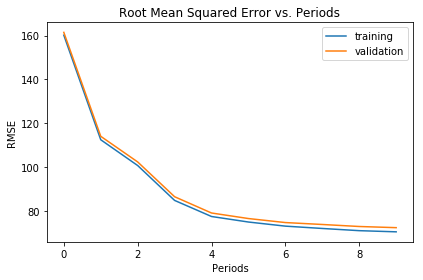

In [12]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
  processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
  processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
  processed_features["population"] = linear_scale(examples_dataframe["population"])
  processed_features["households"] = linear_scale(examples_dataframe["households"])
  processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
  processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

## Task 2: Try a Different Optimizer

** Use the Adagrad and Adam optimizers and compare performance.**

The Adagrad optimizer is one alternative. The key insight of Adagrad is that it modifies the learning rate adaptively for each coefficient in a model, monotonically lowering the effective learning rate.  This works great for convex problems, but isn't always ideal for the non-convex problem Neural Net training.  You can use Adagrad by specifying `AdagradOptimizer` instead of `GradientDescentOptimizer`.  Note that you may need to use a larger learning rate with Adagrad.

For non-convex optimization problems, Adam is sometimes more efficient than Adagrad.  To use Adam, invoke the `tf.train.AdamOptimizer` method. This method takes several optional hyperparameters as arguments, but our solution only specifies one of these (`learning_rate`). In a production setting, you should specify and tune the optional hyperparameters carefully.

Training model...
RMSE (on training data):
  period 00 : 236.31
  period 01 : 235.18
  period 02 : 233.87
  period 03 : 232.47
  period 04 : 230.99
  period 05 : 229.44
  period 06 : 227.82
  period 07 : 226.15
  period 08 : 224.42
  period 09 : 222.64
Model training finished.
Final RMSE (on training data):   222.64
Final RMSE (on validation data): 223.53


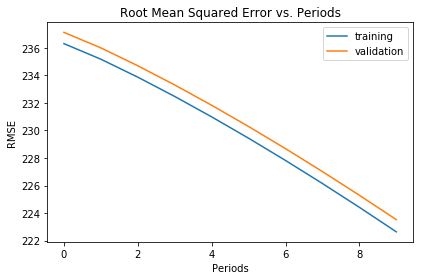

In [13]:
#
# YOUR CODE HERE: Retrain the network using Adagrad and then Adam.
#

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

### Solution

Click below for the solution

First, let's try Adagrad.

Training model...
RMSE (on training data):
  period 00 : 84.21
  period 01 : 75.16
  period 02 : 72.06
  period 03 : 72.05
  period 04 : 73.02
  period 05 : 73.27
  period 06 : 71.30
  period 07 : 69.72
  period 08 : 68.34
  period 09 : 70.26
Model training finished.
Final RMSE (on training data):   70.26
Final RMSE (on validation data): 72.77


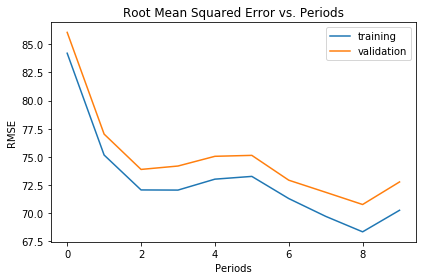

In [14]:
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Now let's try Adam.

Training model...
RMSE (on training data):
  period 00 : 227.52
  period 01 : 178.23
  period 02 : 120.89
  period 03 : 115.14
  period 04 : 109.90
  period 05 : 101.23
  period 06 : 89.12
  period 07 : 77.36
  period 08 : 71.89
  period 09 : 70.89
Model training finished.
Final RMSE (on training data):   70.89
Final RMSE (on validation data): 72.95


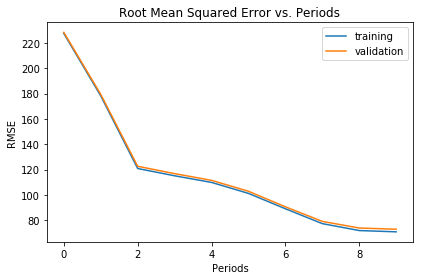

In [15]:
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.009),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Let's print a graph of loss metrics side by side.

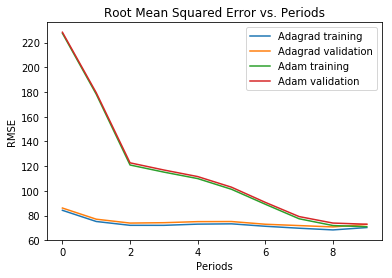

In [16]:
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()

## Task 3: Explore Alternate Normalization Methods

**Try alternate normalizations for various features to further improve performance.**

If you look closely at summary stats for your transformed data, you may notice that linear scaling some features leaves them clumped close to `-1`.

For example, many features have a median of `-0.8` or so, rather than `0.0`.

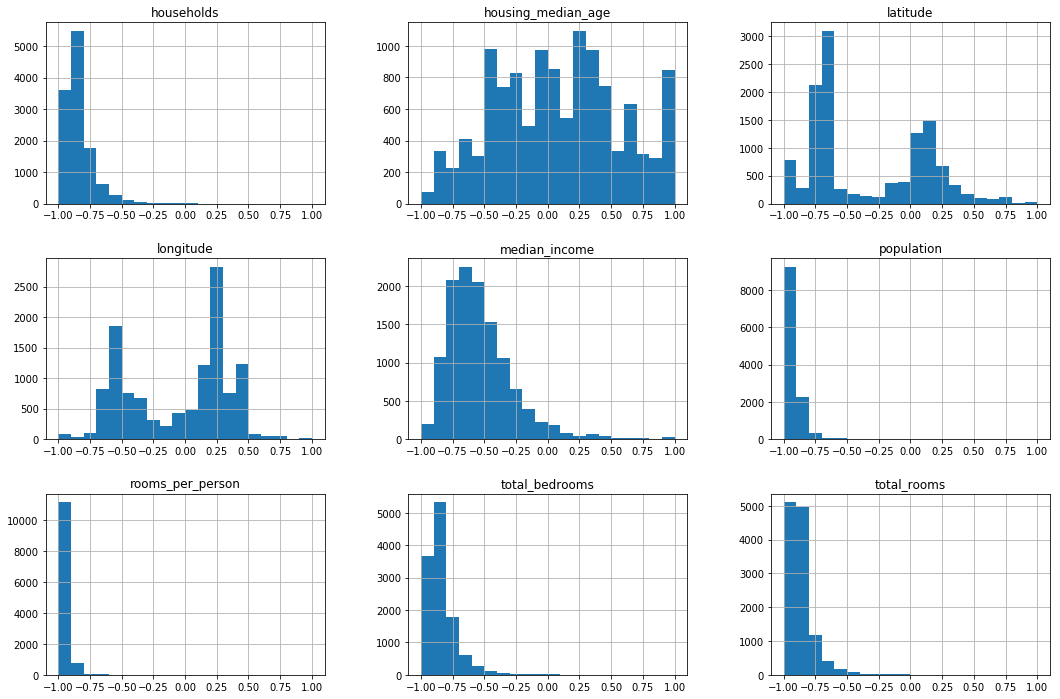

In [17]:
_ = normalized_training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

We might be able to do better by choosing additional ways to transform these features.

For example, a log scaling might help some features.  Or clipping extreme values may make the remainder of the scale more informative.

In [18]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

The block above contains a few additional possible normalization functions. Try some of these, or add your own.

Note that if you normalize the target, you'll need to un-normalize the predictions for loss metrics to be comparable.

Training model...
RMSE (on training data):
  period 00 : 96.94
  period 01 : 79.78
  period 02 : 74.83
  period 03 : 73.47
  period 04 : 72.97
  period 05 : 72.77
  period 06 : 73.63
  period 07 : 71.90
  period 08 : 71.83
  period 09 : 71.51
Model training finished.
Final RMSE (on training data):   71.51
Final RMSE (on validation data): 73.49


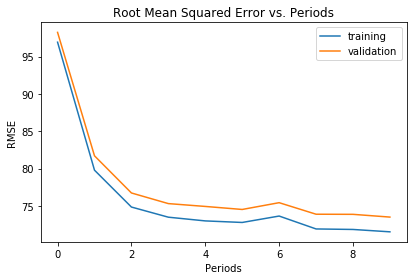

In [26]:
def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
#   processed_features = examples_dataframe
#   for key,value in dict(examples_dataframe).items():
#     processed_features[key] = linear_scale(value)

  processed_features = pd.DataFrame()
    
  processed_features["households"] = clip(examples_dataframe["households"], 2.1, 10000)
  processed_features["households"] = log_normalize(processed_features["households"])

  processed_features["median_income"] = clip(examples_dataframe["median_income"], 0.51, 14.9)
  processed_features["median_income"] = log_normalize(processed_features["median_income"])

  processed_features["total_bedrooms"] = clip(examples_dataframe["total_bedrooms"], 3.1, 100000)
  processed_features["total_bedrooms"] = log_normalize(processed_features["total_bedrooms"])  
  
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  
  processed_features["housing_median_age"] = clip(examples_dataframe["housing_median_age"], 2.1, 1000 )
  processed_features["housing_median_age"] = linear_scale(processed_features["housing_median_age"])
  
  processed_features["total_rooms"] = clip(examples_dataframe["total_rooms"], 11.1, 50000)
  processed_features["total_rooms"] = linear_scale(processed_features["total_rooms"])
  
  processed_features["population"] = clip(examples_dataframe["population"], 6.1, 100000)
  processed_features["population"] = linear_scale(processed_features["population"])    
  
  processed_features["rooms_per_person"] = clip(examples_dataframe["rooms_per_person"], 0, 55.1)
  processed_features["rooms_per_person"] = linear_scale(processed_features["rooms_per_person"])
    
  return processed_features


normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.15),
    steps=1000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

### Solution

Click below for one possible solution.

These are only a few ways in which we could think about the data. Other transformations may work even better!

`households`, `median_income` and `total_bedrooms` all appear normally-distributed in a log space.

`latitude`, `longitude` and `housing_median_age` would probably be better off just scaled linearly, as before.

`population`, `totalRooms` and `rooms_per_person` have a few extreme outliers. They seem too extreme for log normalization to help. So let's clip them instead.

Training model...
RMSE (on training data):
  period 00 : 86.38
  period 01 : 74.20
  period 02 : 71.92
  period 03 : 71.53
  period 04 : 69.73
  period 05 : 69.08
  period 06 : 68.62
  period 07 : 68.66
  period 08 : 67.63
  period 09 : 67.32
Model training finished.
Final RMSE (on training data):   67.32
Final RMSE (on validation data): 69.43


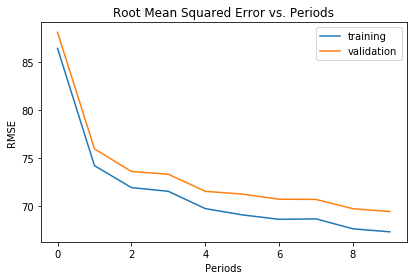

In [23]:
def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  processed_features = pd.DataFrame()

  processed_features["households"] = log_normalize(examples_dataframe["households"])
  processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
  processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])
  
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

  processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
  processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
  processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

  return processed_features

normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.15),
    steps=1000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

## Optional Challenge: Use only Latitude and Longitude Features

**Train a NN model that uses only latitude and longitude as features.**

Real estate people are fond of saying that location is the only important feature in housing price.
Let's see if we can confirm this by training a model that uses only latitude and longitude as features.

This will only work well if our NN can learn complex nonlinearities from latitude and longitude.

**NOTE:** We may need a network structure that has more layers than were useful earlier in the exercise.

Training model...
RMSE (on training data):
  period 00 : 109.40
  period 01 : 100.71
  period 02 : 97.61
  period 03 : 97.45
  period 04 : 96.97
  period 05 : 96.37
  period 06 : 95.52
  period 07 : 95.43
  period 08 : 96.11
  period 09 : 94.50
Model training finished.
Final RMSE (on training data):   94.50
Final RMSE (on validation data): 97.02


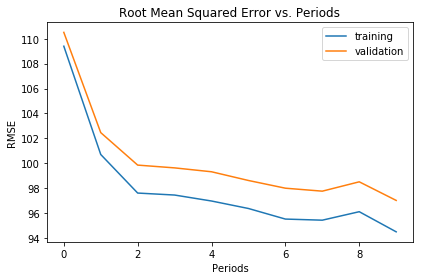

In [35]:
#
# YOUR CODE HERE: Train the network using only latitude and longitude
#
def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  processed_features = pd.DataFrame()
  
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])

  return processed_features

normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.009),
    steps=1000,
    batch_size=100,
    hidden_units=[20, 20, 10, 10, 5, 5],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

### Solution

Click below for a possible solution.

It's a good idea to keep latitude and longitude normalized:

Training model...
RMSE (on training data):
  period 00 : 154.04
  period 01 : 106.77
  period 02 : 104.61
  period 03 : 103.66
  period 04 : 102.17
  period 05 : 101.24
  period 06 : 100.76
  period 07 : 99.82
  period 08 : 99.51
  period 09 : 99.61
Model training finished.
Final RMSE (on training data):   99.61
Final RMSE (on validation data): 101.40


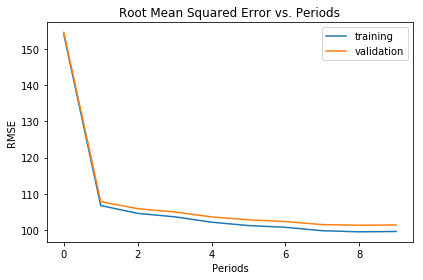

In [36]:
def location_location_location(examples_dataframe):
  """Returns a version of the input `DataFrame` that keeps only the latitude and longitude."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  return processed_features

lll_dataframe = location_location_location(preprocess_features(california_housing_dataframe))
lll_training_examples = lll_dataframe.head(12000)
lll_validation_examples = lll_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    steps=500,
    batch_size=50,
    hidden_units=[10, 10, 5, 5, 5],
    training_examples=lll_training_examples,
    training_targets=training_targets,
    validation_examples=lll_validation_examples,
    validation_targets=validation_targets)

This isn't too bad for just two features. Of course, property values can still vary significantly within short distances.